# Predicts landcover data

Script to get extract data from Esri 2020 10m landcover 
for locations in the PREDICTs biodiveristy dataset

## Steps
1. Read PREDICTS locations as points
2. Buffer points (1km)
3. Read landcover in those areas
4. Calculate summary stats by class
5. Write to csv

In [1]:
# 0. Install cog_worker library
!pip install --upgrade --quiet --no-cache-dir cog_worker

In [2]:
# 0. Load secrets from .env file
%load_ext dotenv
%dotenv .env

In [3]:
# 0. Import libraries
import geopandas as gpd
import pandas as pd
import cog_worker
import pystac_client
import rasterio as rio
import numpy as np
import json
import os

In [4]:
# 1.1 Load points

sites = pd.read_csv('PREDICTS1_sites.csv')
sites

,Unnamed: 0,UniqueID,Longitude,Latitude,Year
0,1,AD1_2001__Liow 1 1,103.778611,1.351944,1999
1,2,AD1_2001__Liow 1 2,103.808056,1.354722,1999
2,3,AD1_2001__Liow 1 3,103.811667,1.394722,1999
3,4,AD1_2001__Liow 1 4,103.787222,1.326944,1999
4,5,AD1_2001__Liow 1 5,103.803611,1.282778,1999
...,...,...,...,...,...
36021,36022,YY1_2018__Guillemot 1 63,75.343770,12.225680,2017
36022,36023,YY1_2018__Guillemot 1 64,75.343790,12.225700,2017
36023,36024,YY1_2018__Guillemot 1 65,75.480130,12.192230,2017
36024,36025,YY1_2018__Guillemot 1 66,75.480220,12.192130,2017


<AxesSubplot:>

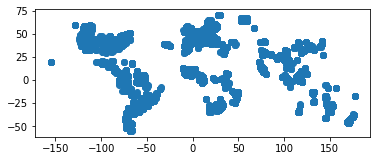

In [5]:
# 1.2 Convert to geometries

pts = gpd.points_from_xy(sites.Longitude, sites.Latitude, crs=4326)
sites_with_geom = gpd.GeoDataFrame(sites, geometry=pts)
sites_with_geom.plot()

<AxesSubplot:>

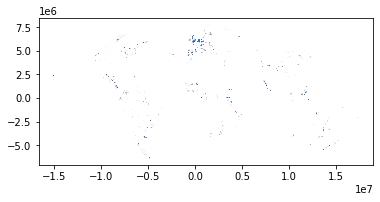

In [6]:
# 2. Buffer points to 1km in Molleweide projection

buffered_points = sites_with_geom.to_crs('+proj=moll').buffer(1000)
buffered_points.plot()

In [7]:
# 3. Functions to get assets for a geometry

def stac_search(url, **kwargs):
    '''Search STAC catalog'''
    client = pystac_client.Client.open(url, ignore_conformance=True) 
    # 1 io-stac-internal must ignore conformance
    try: 
        search = client.search(limit=10000, **kwargs)
        # io-stac-internal on old version of stac-fastapi cannot paginate
        items = search.get_items()
        return [asset.href for item in items for asset in item.assets.values()]
    except Exception as e:  
        if e.args[0] == '{"detail":"No features found"}':
            # stac-fastapi returns 404 instead of empty list when none found
            return []
        raise e
        
def read_stac_collection_for_geometry(
        url,
        collection_id, 
        geom,
        scale=1000,
        proj='+proj=moll',
        datetime=None
    ):
    '''Read assets in a STAC collection for a geometry'''
    # 1. Instantiate a cog_worker to read the COG at for a given projection, scale, and bounds
    bounds = geom.bounds
    reader = cog_worker.Worker(proj_bounds=bounds, proj=proj, scale=scale)

    # 2. Seach for assets in that area and read them
    search_bbox = reader.lnglat_bounds() # search has to be lng/lat
    assets = stac_search(url, collections=[collection_id], bbox=search_bbox, datetime=datetime)
    arr = reader.read(assets)
    
    # 3. Mask the array to the geometry
    mask = _mask_from_geom(reader, geom)
    arr.mask = np.logical_or(arr.mask, np.logical_not(mask))
    return arr
    
def _mask_from_geom(reader: cog_worker.Worker, geom):
    '''Rasterize a geometry at a cog_worker's bounds and scale (crs must match)'''
    shape = (reader.width+reader.buffer*2, reader.height+reader.buffer*2)
    affine = rio.transform.from_bounds(*reader.bounds, *shape)
    return rio.features.rasterize(((geom, 255),), out_shape=shape, transform=affine)[np.newaxis]



Found assets: ['/vsiaz/io-vizz-dynamic-science/esri-2020-land-cover-10m/global_lulc.tif']
Asset metadata: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 2172513, 'height': 991447, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00016570627047201875, 0.0, -179.99999998730883,
       0.0, -0.0001657068215416194, 83.77604689492836)}


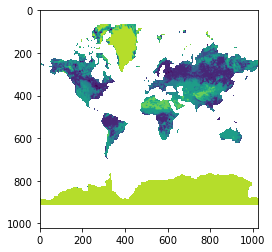

<AxesSubplot:>

In [8]:
# 3.2 Test STAC read

STAC_API_URL = 'http://io-stac-internal.azurewebsites.net'
COLLECTION_ID = 'esri-2020-land-cover-10m'
YEAR = 2020

assets = stac_search(
    url=STAC_API_URL,
    collections=[COLLECTION_ID],
    datetime=f'{YEAR}-01-01/{YEAR}-12-31'
)
print("Found assets:", assets)

# Read metadata headers with rasterio
with rio.open(assets[0]) as src:
    print("Asset metadata:", src.meta)

# Read a low overview of the 10m data
arr, bbox = cog_worker.Manager().preview(lambda x: x.read(assets[0]))
rio.plot.show(arr)

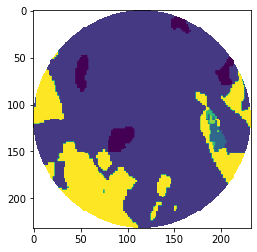

<AxesSubplot:>

In [9]:
# 3.3 Test STAC Read

arr = read_stac_collection_for_geometry(
    url=STAC_API_URL,
    geom=buffered_points[0],
    collection_id=COLLECTION_ID,
    scale=10,
    proj='+proj=moll'
)
rio.plot.show(arr)

In [10]:
# 4.1 Read data for each geometry in order and generate summary stats

def get_landcover_freq(geom):
    arr = read_stac_collection_for_geometry(
        url=STAC_API_URL,
        geom=geom,
        collection_id=COLLECTION_ID,
        scale=10,
        proj='+proj=moll'
    )
    arr = arr.compressed()  # flatten array and discard masked data
    values, counts = np.unique(arr, return_counts=True)
    total_count = sum(counts)
    counts = [c/total_count for c in counts]  # normalize to 0-1
    return dict(zip(values, counts))

geom = buffered_points[0]
get_landcover_freq(geom)

{1: 0.036059514783927216,
 2: 0.7640731614859743,
 3: 0.008908263836239575,
 5: 0.0020375284306292647,
 6: 0.000971379833206975,
 7: 0.18795015163002274}

In [11]:
# 5. compute results for each point and write to csv

LIMIT = 15
results = []
for i, geom in enumerate(buffered_points[:LIMIT]):
    print(f'Point {i} of {len(buffered_points)}', flush=True)
    results.append(get_landcover_freq(geom))
results = pd.DataFrame(results, index=sites_with_geom.index[:LIMIT])
results.to_csv('predicts_1km_lc_2020_test.csv')
results

Point 0 of 36026
Point 1 of 36026
Point 2 of 36026
Point 3 of 36026
Point 4 of 36026
Point 5 of 36026
Point 6 of 36026
Point 7 of 36026
Point 8 of 36026
Point 9 of 36026
Point 10 of 36026
Point 11 of 36026
Point 12 of 36026
Point 13 of 36026
Point 14 of 36026


,1,2,3,5,6,7,8
0,0.036060,0.764073,0.008908,0.002038,0.000971,0.187950,NaN
1,0.040964,0.795181,0.058970,NaN,0.008695,0.086998,0.009193
2,0.068660,0.753980,0.033690,NaN,NaN,0.143669,NaN
3,NaN,0.230951,0.038429,NaN,0.008079,0.722541,NaN
4,NaN,0.097896,0.003033,NaN,NaN,0.899071,NaN
5,0.036060,0.764073,0.008908,0.002038,0.000971,0.187950,NaN
6,0.040964,0.795181,0.058970,NaN,0.008695,0.086998,0.009193
7,0.068660,0.753980,0.033690,NaN,NaN,0.143669,NaN
8,NaN,0.230951,0.038429,NaN,0.008079,0.722541,NaN
9,NaN,0.097896,0.003033,NaN,NaN,0.899071,NaN


# Using dask

In [12]:
# 0. import libraries
import dask
from dask.distributed import Client, PipInstall
import dask_gateway


In [13]:
# 1. parallelize by multiprocessing in a dask LocalCluster

# Instantiate a client, creating a local cluster
client = Client()
client.close()

In [14]:
# Connect to the Platenary Computer Dask Gateway
gateway = dask_gateway.Gateway()
gateway.cluster_options()

In [15]:
# Instatiate a new cluster and scale it to 1 worker
cluster = gateway.new_cluster()
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.6abc0545d83546ed97ed48db0577a9c1/status


In [16]:
# Try computing something on the gateway
client = cluster.get_client()
cluster.scale(1)

rands = dask.delayed(np.random.random)((10000, 10000))
rands_sqrt = dask.delayed(np.sqrt)(rands)
future = client.compute(rands_sqrt)
future.result()

array([[0.60628287, 0.43864005, 0.51507442, ..., 0.93108925, 0.37463044,
        0.78981351],
       [0.4214264 , 0.06875615, 0.21843908, ..., 0.56287428, 0.46045831,
        0.49977505],
       [0.7857518 , 0.20877713, 0.57867809, ..., 0.6851317 , 0.68534214,
        0.3566765 ],
       ...,
       [0.9959555 , 0.88437361, 0.83425883, ..., 0.91628775, 0.55400775,
        0.58873595],
       [0.72975505, 0.63188954, 0.82051397, ..., 0.34375928, 0.95852455,
        0.68272302],
       [0.96192888, 0.9089775 , 0.82997921, ..., 0.27985961, 0.68806772,
        0.30912677]])

In [17]:
# Release the cluster and gateway
client.close()
cluster.close()
gateway.close()

In [18]:
# Putting it all together

In [19]:
# Solution

'''
# Create delayed functions as tasks to execute in the cluster
tasks = []

def _wrapper(i, geom):
    # wrap the function to add a print statement
    print(f'Point {i} of {len(buffered_points)}', flush=True)
    return get_landcover_freq(geom)

for i, geom in enumerate(buffered_points[:LIMIT]):
    delayed = dask.delayed(_wrapper)(i, geom)
    tasks.append(delayed)

# Send tasks to cluster to execute
futures = client.compute(tasks, retries=2)

# Wait for tasks to complete
results = client.gather(futures)
results = pd.DataFrame(results, index=sites_with_geom.index[:LIMIT])

# Close local cluster
client.close()
results
'''

"\n# Create delayed functions as tasks to execute in the cluster\ntasks = []\n\ndef _wrapper(i, geom):\n    # wrap the function to add a print statement\n    print(f'Point {i} of {len(buffered_points)}', flush=True)\n    return get_landcover_freq(geom)\n\nfor i, geom in enumerate(buffered_points[:LIMIT]):\n    delayed = dask.delayed(_wrapper)(i, geom)\n    tasks.append(delayed)\n\n# Send tasks to cluster to execute\nfutures = client.compute(tasks, retries=2)\n\n# Wait for tasks to complete\nresults = client.gather(futures)\nresults = pd.DataFrame(results, index=sites_with_geom.index[:LIMIT])\n\n# Close local cluster\nclient.close()\nresults\n"

In [20]:
'''
cluster_options = {
    'worker_memory':2,
    'environment':{
        'AZURE_SAS': os.getenv('AZURE_SAS'),
        'AZURE_STORAGE_ACCOUNT': os.getenv('AZURE_STORAGE_ACCOUNT'),
        'DASK_DISTRIBUTED__SCHEDULER__ALLOWED_FAILURES': '3',
    }
}
requirements = ['cog_worker']

tasks = [
    dask.delayed(get_landcover_freq)(geom)
    for geom in buffered_points
]

# Use context managers to auto-close when tasks are done or failed
with dask_gateway.Gateway() as gateway, \
    gateway.new_cluster(**cluster_options) as cluster, \
    cluster.get_client() as client:
        print (cluster.dashboard_link)
    
        # install necessary libraries
        plugin = PipInstall(packages=requirements, pip_options=['--upgrade'])
        client.register_worker_plugin(plugin)
        
        # autoscale cluster
        cluster.adapt(1, 16)
        
        # compute tasks
        futures = client.compute(tasks, retries=3)
        
        # stream in results as they are compeleted
        results = []
        count = 0
        for future, result in dask.distributed.as_completed(futures, with_results=True):
            results.append(result)
            count += 1
            if count % 100 == 0:
                print(count)

results = pd.DataFrame(results, index=sites_with_geom.index)
results.to_csv('predicts_1km_lc_2020.csv')
results
'''

"\ncluster_options = {\n    'worker_memory':2,\n    'environment':{\n        'AZURE_SAS': os.getenv('AZURE_SAS'),\n        'AZURE_STORAGE_ACCOUNT': os.getenv('AZURE_STORAGE_ACCOUNT'),\n        'DASK_DISTRIBUTED__SCHEDULER__ALLOWED_FAILURES': '3',\n    }\n}\nrequirements = ['cog_worker']\n\ntasks = [\n    dask.delayed(get_landcover_freq)(geom)\n    for geom in buffered_points\n]\n\n# Use context managers to auto-close when tasks are done or failed\nwith dask_gateway.Gateway() as gateway,     gateway.new_cluster(**cluster_options) as cluster,     cluster.get_client() as client:\n        print (cluster.dashboard_link)\n    \n        # install necessary libraries\n        plugin = PipInstall(packages=requirements, pip_options=['--upgrade'])\n        client.register_worker_plugin(plugin)\n        \n        # autoscale cluster\n        cluster.adapt(1, 16)\n        \n        # compute tasks\n        futures = client.compute(tasks, retries=3)\n        \n        # stream in results as they are